# Spatio-Temporal Hotspot Exploration — Squid Catch (2000–2020)

This notebook performs exploratory analysis on squid fishing hotspots derived
from PostGIS. It focuses on temporal trends in catch, effort, and CPUE, and
serves as a validation step prior to visualization in QGIS and dashboarding.


In [1]:

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sqlalchemy import create_engine
from dotenv import load_dotenv
load_dotenv()


True

## Connect to PostGIS Database

We connect directly to the PostgreSQL/PostGIS database to query
analysis-ready hotspot tables.

In [2]:

pguser = os.getenv("PGUSER")
pgpassword = os.getenv("PGPASSWORD")
pghost = os.getenv("PGHOST")
pgport = os.getenv("PGPORT")
pgdatabase = os.getenv("PGDATABASE")

assert all([pguser, pgpassword, pghost, pgport, pgdatabase]), \
    "One or more PostgreSQL environment variables are missing"

engine = create_engine(
    f"postgresql://{pguser}:{pgpassword}@{pghost}:{pgport}/{pgdatabase}"
)


## Load Hotspot Data

The `analysis.squid_hotspots` table contains spatially aggregated fishing
events with total catch and vessel-day effort.

In [3]:
sql = """
SELECT
    year,
    total_catch_kg,
    vessel_days,
    cell_geom,
    total_catch_kg / NULLIF(vessel_days, 0) AS cpue
FROM analysis.squid_hotspots

"""

hotspots = gpd.read_postgis(
    sql,
    engine,
    geom_col="cell_geom",
    crs="EPSG:4326"
)

hotspots.head()

,year,total_catch_kg,vessel_days,cell_geom,cpue
0,2000,1.179073e+06,14,POINT (-66.5 -53.25),84219.519961
1,2000,1.030616e+06,14,POINT (-66.25 -53.25),73615.427836
2,2000,3.752414e+05,4,POINT (-66.5 -53.5),93810.358550
3,2000,2.658457e+05,5,POINT (-66.25 -53.5),53169.138984
4,2000,1.726157e+04,3,POINT (-66.25 -53.75),5753.857613


## Temporal Trends

We summarize total catch, effort, and CPUE by year to inspect long-term trends.

In [4]:
summary = (
    hotspots
    .groupby("year")
    .agg(
        total_catch_kg=("total_catch_kg", "sum"),
        vessel_days=("vessel_days", "sum"),
        cpue=("cpue", "mean")
    )
    .reset_index()
)

summary.head()

,year,total_catch_kg,vessel_days,cpue
0,2000,2.479350e+08,4049,28520.665423
1,2001,1.319413e+08,3290,20139.631138
2,2002,8.820531e+07,3002,11049.638792
3,2003,1.217928e+08,2899,17493.479104
4,2004,9.786551e+06,1613,2663.398176


## Catch and CPUE Over Time

This plot provides a high-level view of fishing intensity and efficiency.

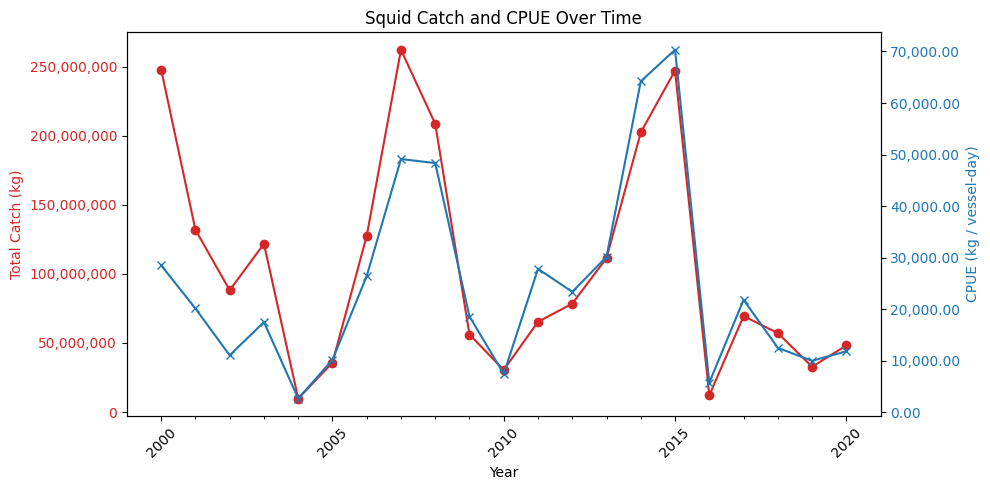

In [5]:

# Ensure year is integer
summary["year"] = summary["year"].astype(int)

fig, ax1 = plt.subplots(figsize=(10,5))

# Plot Total Catch (kg) with thousands separators
ax1.plot(summary["year"], summary["total_catch_kg"], color="tab:red", marker='o')
ax1.set_ylabel("Total Catch (kg)", color="tab:red")
ax1.tick_params(axis='y', labelcolor="tab:red")
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Twin axis for CPUE
ax2 = ax1.twinx()
ax2.plot(summary["year"], summary["cpue"], color="tab:blue", marker='x')
ax2.set_ylabel("CPUE (kg / vessel-day)", color="tab:blue")
ax2.tick_params(axis='y', labelcolor="tab:blue")
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.2f}'))

# Reduce X-axis ticks: show every 5th year
years = summary["year"]
ax1.set_xticks(years[::5])  # main ticks every 5 years
ax1.set_xticklabels(years[::5], rotation=45)  # labels for those ticks

# Minor ticks as ruler (optional, no labels)
ax1.set_xticks(years, minor=True)

# X-axis label at the bottom
ax1.set_xlabel("Year")

# Title and layout
plt.title("Squid Catch and CPUE Over Time")
plt.tight_layout()

# Create outputs folder if it doesn't exist
os.makedirs("outputs/plots", exist_ok=True)

# Save figure
plt.savefig("../outputs/plots/squid_catch_cpue_over_time.png", dpi=300, bbox_inches='tight')

plt.show()



## Spatial Distribution Check

A simple spatial plot to verify hotspot geometry and distribution.

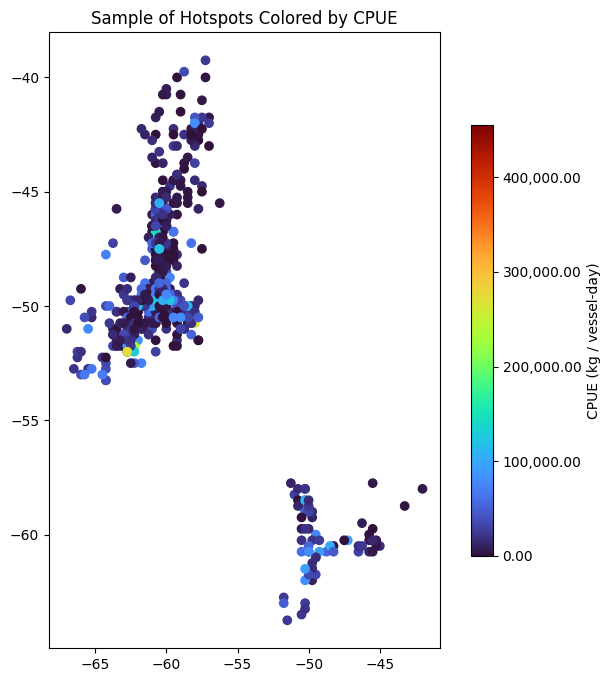

In [8]:

# Ensure reproducible sample
sample_hotspots = hotspots.sample(500, random_state=42)

# Fixed color scale based on full dataset
vmin = hotspots["cpue"].min()
vmax = hotspots["cpue"].max()

# Plot
ax = sample_hotspots.plot(
    column="cpue",
    cmap="turbo",
    legend=True,
    figsize=(8,8),
    vmin=vmin,
    vmax=vmax,
    legend_kwds={
        "label": "CPUE (kg / vessel-day)",
        "orientation": "vertical",
        "shrink": 0.7
        # Removed 'formatter' from here
    }
)

# Apply formatter to the colorbar after plotting
cbar = ax.get_figure().get_axes()[1]  # usually the colorbar is the second axes
cbar.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.2f}"))

plt.title("Sample of Hotspots Colored by CPUE")

# Ensure outputs folder exists
os.makedirs("../outputs/plots", exist_ok=True)

# Save figure
plt.savefig("../outputs/plots/sample_of_hotspots_colored_by_cpue.png", dpi=300, bbox_inches='tight')

plt.show()



## Notes

This exploratory step confirms temporal trends and spatial coherence
of hotspot data prior to cartographic styling in QGIS and integration
into interactive dashboards.